# Forecasting NHS staff turnover using Prophet

Data from NHS Digital (Legacy) Workforce Statistics, "Turnover from organisation benchmarking source data, October 2022" https://digital.nhs.uk/data-and-information/publications/statistical/nhs-workforce-statistics/october-2022  
Excel PowerQuery used to wrangle data into usable format.

## Load and explore data

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from prophet import Prophet

import prophet

#should be version 1.0 according to course but that is not working so trying with latest
prophet.__version__

'1.1.2'

In [3]:
from forecast_tools.model_selection import auto_naive
from forecast_tools.metrics import mean_absolute_error

Load in data (pre-processed), rename some columns and then look at info about loaded data and top 5 rows.

In [4]:
url = './02_data/2023-01_turnover_monthly_csv.csv'
pr_y_train = pd.read_csv(url, parse_dates=['Date'], 
                            dayfirst=True)
                         #,index_col='Date')
pr_y_train.rename(columns={'SIP.FTE':'SIP_FTE','SIP.HC':'SIP_HC'},inplace=True)
pr_y_train['Date'] = pd.to_datetime(pr_y_train['Date'])
#df = df.set_index(['Date', 'Staff group', 'Org code'])
pr_y_train = pr_y_train.sort_values(by='Date')
pr_y_train.info()
#pr_y_train.index.freq = 'D'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228976 entries, 0 to 228975
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              228976 non-null  datetime64[ns]
 1   Type              228976 non-null  object        
 2   Org code          228976 non-null  object        
 3   Org name          228976 non-null  object        
 4   NHSE region code  228976 non-null  object        
 5   NHSE region name  228976 non-null  object        
 6   ICS code          228976 non-null  object        
 7   ICS name          228976 non-null  object        
 8   Cluster group     228976 non-null  object        
 9   Benchmark group   228976 non-null  object        
 10  Staff group       228976 non-null  object        
 11  HC                228976 non-null  int64         
 12  FTE               228976 non-null  float64       
 13  SIP_HC            228017 non-null  float64       
 14  SIP_

In [5]:
pr_y_train.head()

,Date,Type,Org code,Org name,NHSE region code,NHSE region name,ICS code,ICS name,Cluster group,Benchmark group,Staff group,HC,FTE,SIP_HC,SIP_FTE
0,2018-08-01,Joiners,RVV,East Kent Hospitals University NHS Foundation ...,Y59,South East,QKS,Kent and Medway,Acute,Acute - Teaching,Managers,8,7.67500,108.0,105.15500
2710,2018-08-01,Leavers,RV5,South London and Maudsley NHS Foundation Trust,Y56,London,QKK,South East London,Mental Health,Mental Health and Learning Disability,HCHS doctors (exc. junior Drs),5,4.05195,248.0,218.53954
2711,2018-08-01,Joiners,RBZ,Northern Devon Healthcare NHS Trust,Y58,South West,QJK,Devon,Acute,Acute - Small,All staff groups,58,51.97166,2984.0,2497.48221
2712,2018-08-01,Joiners,RV5,South London and Maudsley NHS Foundation Trust,Y56,London,QKK,South East London,Mental Health,Mental Health and Learning Disability,HCHS doctors (exc. junior Drs),5,4.00000,248.0,218.53954
2713,2018-08-01,Joiners,07H,NHS West Essex CCG,Y61,East of England,QM7,Hertfordshire and West Essex,Clinical Commissioning Group,Clinical Commissioning Group,Nurses & health visitors,2,1.21333,18.0,13.88666


The data show the full time equivalent (FTE) and headcount (HC) number of leavers and joiners by organisation and staff group for the previous 12-month period from the date. It also shows the number of staff in post (SIP) HC and FTE averaged over the 12-month period to date.

Drop joiners data to create leavers dataframe. Then drop some staff groups not of interest and drop CCGs and ICBs.

In [7]:
df_leaver = pr_y_train[pr_y_train.Type == 'Leavers']


staff_groups_todrop = ['Other staff or those with unknown classification','Managers','Senior managers','Central functions','Hotel, property & estates']
df_leaver = df_leaver[~df_leaver['Staff group'].isin(staff_groups_todrop)]

trust_types_todrop = ['Clinical Commissioning Group','Integrated Care Board']
df_leaver_trusts = df_leaver[~df_leaver['Cluster group'].isin(trust_types_todrop)]

df_leaver_acute = df_leaver[df_leaver['Cluster group'] == 'Acute']

df_leaver_trusts.head()

df_leaver.head()

,Date,Type,Org code,Org name,NHSE region code,NHSE region name,ICS code,ICS name,Cluster group,Benchmark group,Staff group,HC,FTE,SIP_HC,SIP_FTE
2710,2018-08-01,Leavers,RV5,South London and Maudsley NHS Foundation Trust,Y56,London,QKK,South East London,Mental Health,Mental Health and Learning Disability,HCHS doctors (exc. junior Drs),5,4.05195,248.0,218.53954
2714,2018-08-01,Leavers,RVV,East Kent Hospitals University NHS Foundation ...,Y59,South East,QKS,Kent and Medway,Acute,Acute - Teaching,"Support to doctors, nurses & midwives",32,28.48508,2049.0,1773.41754
2719,2018-08-01,Leavers,RXA,Cheshire and Wirral Partnership NHS Foundation...,Y62,North West,QYG,Cheshire and Merseyside,Mental Health,Mental Health and Learning Disability,"Support to doctors, nurses & midwives",17,14.42000,913.0,777.65168
2720,2018-08-01,Leavers,00V,NHS Bury CCG,Y62,North West,QOP,Greater Manchester,Clinical Commissioning Group,Clinical Commissioning Group,All staff groups,2,2.00000,96.0,73.91734
2724,2018-08-01,Leavers,RQY,South West London and St George's Mental Healt...,Y56,London,QWE,South West London,Mental Health,Mental Health and Learning Disability,"Scientific, therapeutic & technical staff",9,7.80000,397.0,324.52144


Dataframe of one org for testing

In [8]:
org = 'RAE'

df_org = df_leaver[df_leaver['Org code']==org]

df_org = df_org.groupby(['Date','Staff group']).agg({'FTE':'sum','SIP_FTE':'sum','HC':'sum','SIP_HC':'sum'})
df_org['rate'] = df_org['FTE']/df_org['SIP_FTE']
#df_org

Graph of "all staff" leaver rate in the one testing org over time.

In [88]:
#_ = sg_df['rate'].plot(figsize=(15,6))
#df_org.unstack(level=1)['rate']['All staff groups'].plot(figsize=(15,6))

# set the x-axis and y-axis labels
#plt.xlabel('Date')
#plt.ylabel('Rate')
#plt.legend(title='Staff Group')

# display the plot
#plt.show()

Create a new dataframe where dependent variables are aggregated up by date and staff group and add a "rate" column

In [9]:
df_leaver_sg_national = df_leaver.groupby(['Date','Staff group']).agg({'FTE':'sum','SIP_FTE':'sum','HC':'sum','SIP_HC':'sum'})
df_leaver_sg_national['rate'] = df_leaver_sg_national['FTE']/df_leaver_sg_national['SIP_FTE']
df_leaver_sg_national

FTE  \
Date       Staff group                                              
2018-08-01 All staff groups                           12437.76030   
           Ambulance staff                              189.33106   
           HCHS doctors (exc. junior Drs)               736.08561   
           Midwives                                     225.08126   
           Nurses & health visitors                    3214.72794   
...                                                           ...   
2023-01-01 Nurses & health visitors                    4046.49487   
           Scientific, therapeutic & technical staff   2260.95829   
           Support to ST&T staff                       1204.39617   
           Support to ambulance staff                   341.81665   
           Support to doctors, nurses & midwives       3993.63185   

                                                           SIP_FTE     HC  \
Date       Staff group                                                      
2018-08-01 All staff groups                           951687.60600  14577   
           Ambulance staff                             20500.08605    210   
           HCHS doctors (exc. junior Drs)              51582.93875    871   
           Midwives                                    18213.75542    277   
           Nurses & health visitors                   266687.21646   3697   
...                                                            ...    ...   
2023-01-01 Nurses & health visitors                   340498.73102   4722   
           Scientific, therapeutic & technical staff  165618.21866   2582   
           Support to ST&T staff                       78884.99983   1373   
           Support to ambulance staff                  25906.07009    398   
           Support to doctors, nurses & midwives      293538.66495   4784   

                                                         SIP_HC      rate  
Date       Staff group                                                     
2018-08-01 All staff groups                           1086626.0  0.013069  
           Ambulance staff                              21791.0  0.009236  
           HCHS doctors (exc. junior Drs)               56788.0  0.014270  
           Midwives                                     22094.0  0.012358  
           Nurses & health visitors                    299807.0  0.012054  
...                                                         ...       ...  
2023-01-01 Nurses & health visitors                    378329.0  0.011884  
           Scientific, therapeutic & technical staff   188650.0  0.013652  
           Support to ST&T staff                        89407.0  0.015268  
           Support to ambulance staff                   28309.0  0.013194  
           Support to doctors, nurses & midwives       338709.0  0.013605  

[486 rows x 5 columns]

Create a new dataframe where dependent variables are aggregated up by date and staff group and add a "rate" column

In [10]:
df_leaver_trusts_sg = df_leaver_trusts.groupby(['Date','Staff group']).agg({'FTE':'sum','SIP_FTE':'sum','HC':'sum','SIP_HC':'sum'})
df_leaver_trusts_sg['rate'] = df_leaver_trusts_sg['FTE']/df_leaver_trusts_sg['SIP_FTE']


#sg_df.set_index('Date')
df_leaver_trusts_sg.head()
#_ = leaver_df.groupby('Staff group')['FTE'].plot(figsize=(12,4),legend=True)

FTE       SIP_FTE     HC  \
Date       Staff group                                                        
2018-08-01 All staff groups                12311.42991  945012.84769  14432   
           Ambulance staff                   189.33106   20500.08605    210   
           HCHS doctors (exc. junior Drs)    735.13006   51574.58046    867   
           Midwives                          225.08126   18213.75542    277   
           Nurses & health visitors         3201.72127  266289.12818   3681   

                                              SIP_HC      rate  
Date       Staff group                                          
2018-08-01 All staff groups                1079000.0  0.013028  
           Ambulance staff                   21791.0  0.009236  
           HCHS doctors (exc. junior Drs)    56758.0  0.014254  
           Midwives                          22094.0  0.012358  
           Nurses & health visitors         299343.0  0.012023

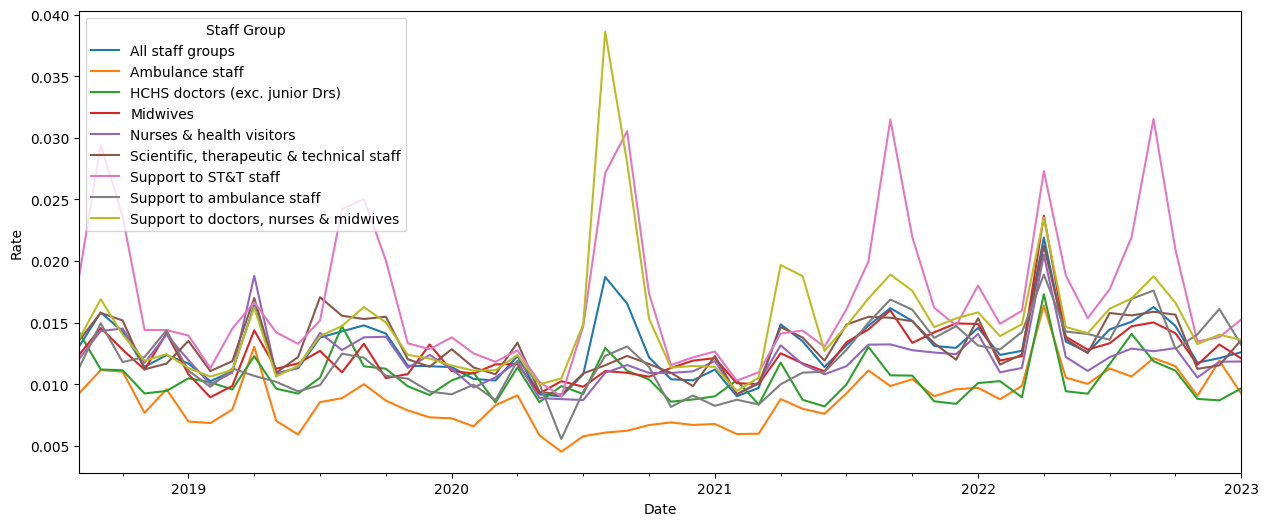

In [11]:
#_ = sg_df['rate'].plot(figsize=(15,6))
df_leaver_trusts_sg.unstack(level=1)['rate'].plot(figsize=(15,6))

# set the x-axis and y-axis labels
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend(title='Staff Group')

# display the plot
plt.show()

Did the coding of Ambulance staff and Support to ambulance staff change at some point, explaining the strange patterns Mar-2019 to Mar-2020?

In [12]:
#_ = sg_df['rate'].plot(figsize=(15,6))

staff_groups_toplot = ['All staff groups','Midwives','Nurses & health visitors']
df_leaver_sg_toplot = df_leaver[df_leaver['Staff group'].isin(staff_groups_toplot)]

df_leaver_sg_toplot = df_leaver_sg_toplot.groupby(['Date','Staff group']).agg({'FTE':'sum','SIP_FTE':'sum','HC':'sum','SIP_HC':'sum'})
df_leaver_sg_toplot['rate'] = df_leaver_sg_toplot['FTE']/df_leaver_sg_toplot['SIP_FTE']

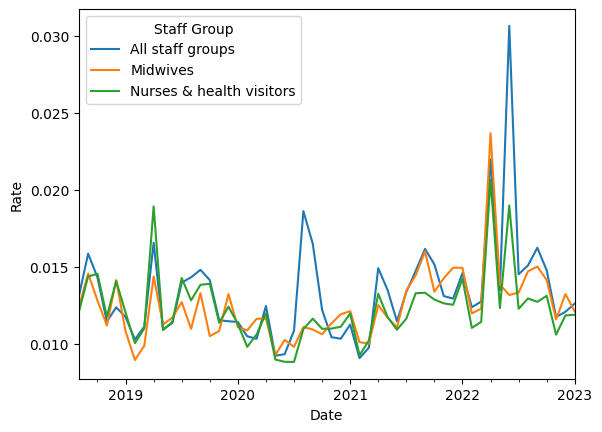

In [13]:
df_leaver_sg_toplot.unstack(level=1)['rate'].plot.line()

# set the x-axis and y-axis labels
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend(title='Staff Group')

# display the plot
plt.show()

## Put data into format suitable for Prophet forecasting

Take the rate column from the dataframe plotted above and specify one staff group. y\_train contains national level leaver rates by month for specified staff group then convert to dataframe.

In [14]:
staff_group = 'Nurses & health visitors'

y_train = df_leaver_trusts_sg.unstack(level=1)['rate'][staff_group]
y_train.head()

Date
2018-08-01    0.012023
2018-09-01    0.014327
2018-10-01    0.014519
2018-11-01    0.011741
2018-12-01    0.014030
Name: Nurses & health visitors, dtype: float64

In [15]:
#y_train.set_index('Date')
y_train = y_train.to_frame()
#y_train['turnover rate'] = y_train['All staff groups']
y_train.head()

,Nurses & health visitors
Date,
2018-08-01,0.012023
2018-09-01,0.014327
2018-10-01,0.014519
2018-11-01,0.011741
2018-12-01,0.014030


The below function converts the training data into the correct format for Prophet giving a dataframe with 2 columns: 'ds': the date; 'y': the leaver rate.

In [16]:
def prophet_training_data(y_train):
    '''
    Converts a standard pandas datetimeindexed dataframe
    for time series into one suitable for Prophet
    Parameters:
    ---------
    y_train: pd.DataFrame
        univariate time series data
        
    Returns:
    --------
        pd.DataFrame in Prophet format 
        columns = ['ds', 'y']
    '''
    prophet_train = pd.DataFrame(y_train.index)
    prophet_train['y'] = y_train.to_numpy()
    prophet_train.columns = ['ds', 'y']

    return prophet_train

Apply function to our data

In [17]:
yp_train = prophet_training_data(y_train)

In [18]:
yp_train.tail()

,ds,y
49,2022-09-01,0.012678
50,2022-10-01,0.012937
51,2022-11-01,0.010543
52,2022-12-01,0.011828
53,2023-01-01,0.011846


## Fit and predict data with Prophet

Create the first Prophet object called 'model', with a 95% interval width. Apply to our data.

In [19]:
#model = Prophet(interval_width=0.95,
#               seasonality_mode='multiplicative')

model = Prophet(interval_width=0.95)
model.fit(yp_train)

13:42:00 - cmdstanpy - INFO - Chain [1] start processing


13:42:01 - cmdstanpy - INFO - Chain [1] done processing


Specify monthly data here in the frequency (freq='MS')

In [20]:
future = model.make_future_dataframe(periods=24, freq='MS')
future

,ds
0,2018-08-01
1,2018-09-01
2,2018-10-01
3,2018-11-01
4,2018-12-01
...,...
73,2024-09-01
74,2024-10-01
75,2024-11-01
76,2024-12-01


In [21]:
prophet_forecast = model.predict(future)
prophet_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
73,2024-09-01,0.013726,0.012834,0.016920,0.013174,0.014286,0.001147,0.001147,0.001147,0.001147,0.001147,0.001147,0.0,0.0,0.0,0.014873
74,2024-10-01,0.013779,0.011847,0.015761,0.013183,0.014382,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.0,0.0,0.0,0.013822
75,2024-11-01,0.013834,0.011441,0.015520,0.013196,0.014480,-0.000251,-0.000251,-0.000251,-0.000251,-0.000251,-0.000251,0.0,0.0,0.0,0.013584
76,2024-12-01,0.013888,0.011511,0.015528,0.013208,0.014575,-0.000374,-0.000374,-0.000374,-0.000374,-0.000374,-0.000374,0.0,0.0,0.0,0.013513
77,2025-01-01,0.013943,0.012903,0.016977,0.013210,0.014677,0.000998,0.000998,0.000998,0.000998,0.000998,0.000998,0.0,0.0,0.0,0.014941


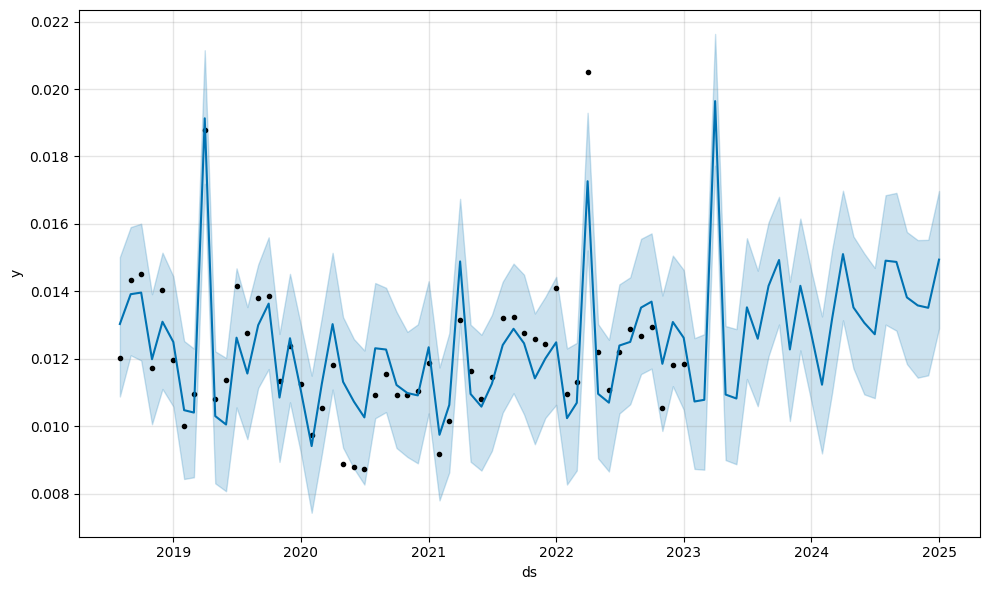

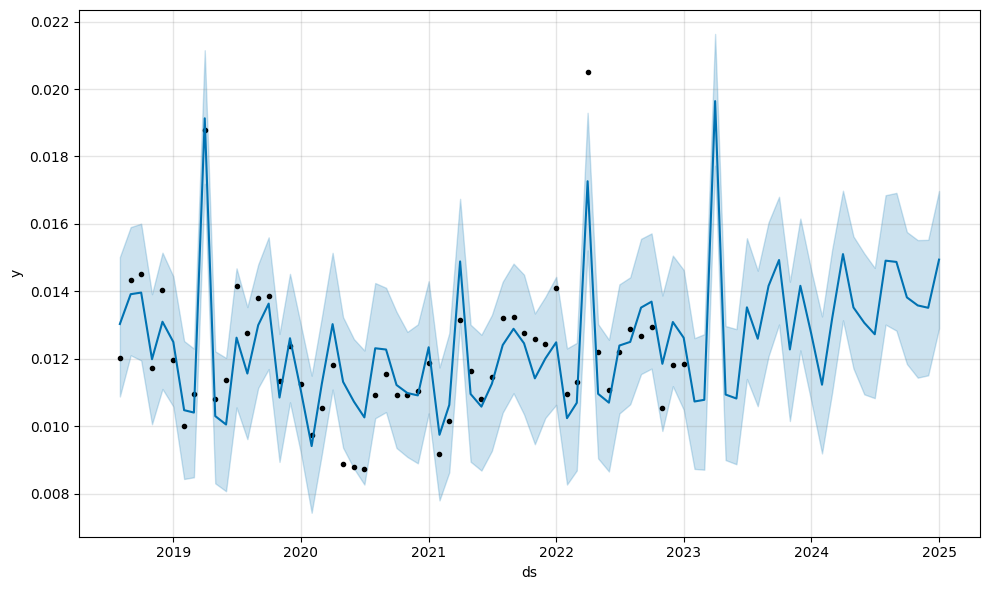

In [113]:
model.plot(prophet_forecast)

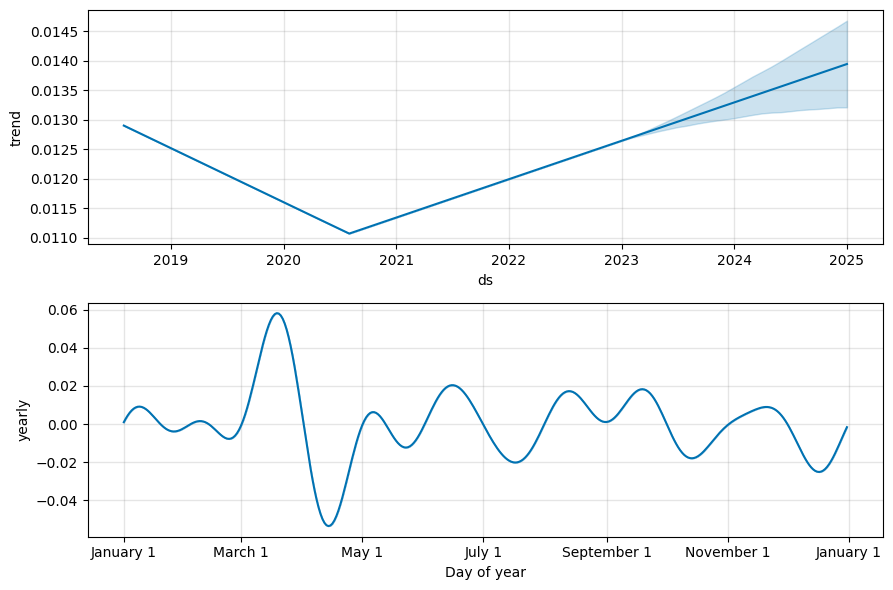

In [24]:
_ = model.plot_components(prophet_forecast)

## Adding changepoints to Prophet

Changepoints are the datetime points where the time series have abrupt changes in the trajectory.

Let’s plot the vertical lines where the potential changepoints occurred

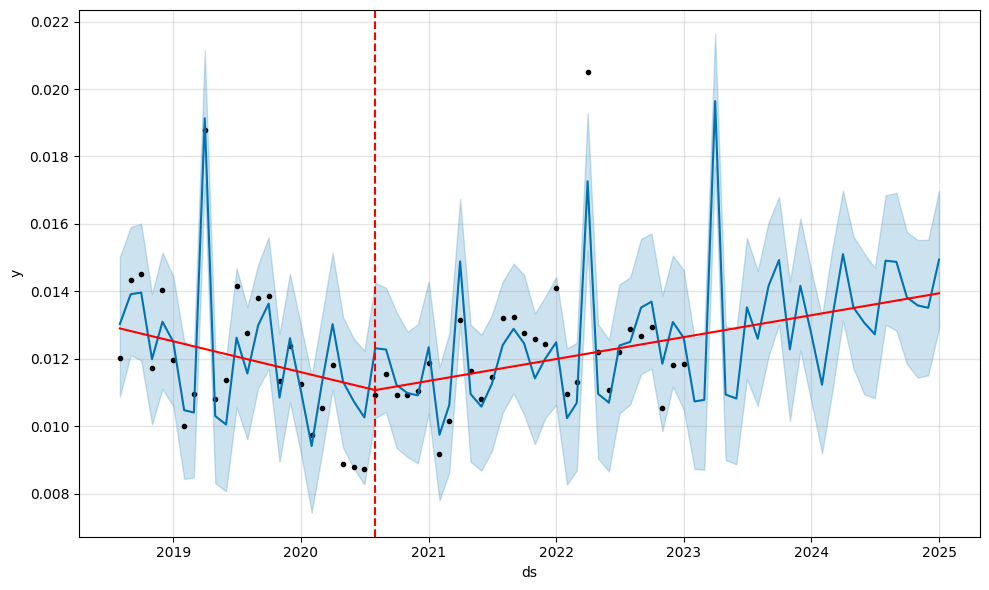

In [25]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(prophet_forecast)
a = add_changepoints_to_plot(fig.gca(), model, prophet_forecast)

In [26]:
model.changepoints

2    2018-10-01
3    2018-11-01
5    2019-01-01
7    2019-03-01
8    2019-04-01
10   2019-06-01
12   2019-08-01
13   2019-09-01
15   2019-11-01
17   2020-01-01
18   2020-02-01
20   2020-04-01
22   2020-06-01
24   2020-08-01
25   2020-09-01
27   2020-11-01
29   2021-01-01
30   2021-02-01
32   2021-04-01
34   2021-06-01
35   2021-07-01
37   2021-09-01
39   2021-11-01
40   2021-12-01
42   2022-02-01
Name: ds, dtype: datetime64[ns]

We can change the inferred changepoint range by setting the changepoint\_range, the number of changepoints with n\_changepoints, and changepoint\_prior\_scale to adjust the trend. 

Default value for changepoint\_prior\_scale is 0.05. Decrease the value to make the trend less flexible. Increase the value of changepoint\_prior\_scale to make the trend more flexible.

13:47:02 - cmdstanpy - INFO - Chain [1] start processing


13:47:03 - cmdstanpy - INFO - Chain [1] done processing


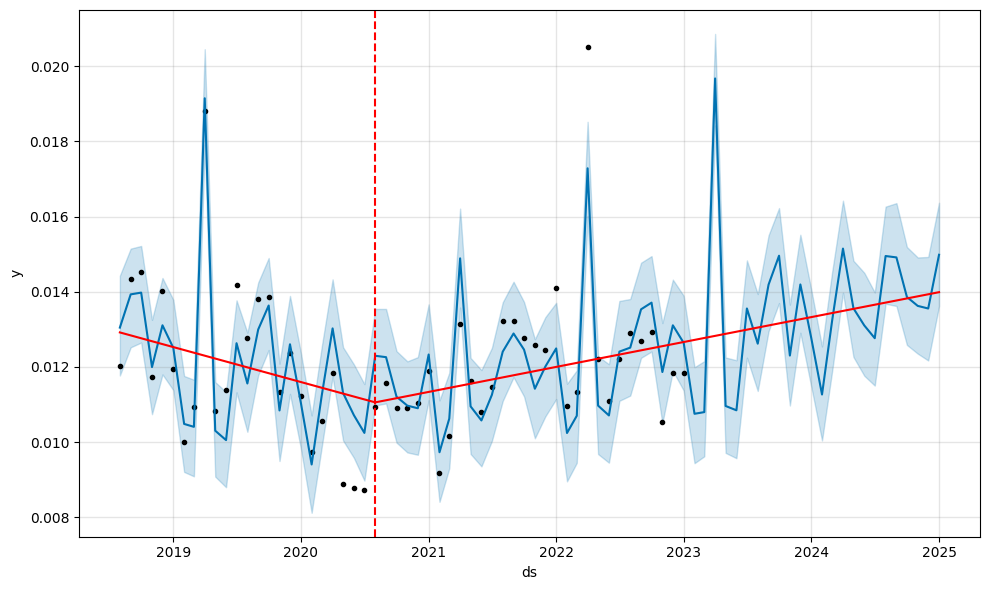

In [31]:
#pro_change = Prophet(changepoint_range=0.9)

model_1 = Prophet(n_changepoints = 45, changepoint_range=0.9, changepoint_prior_scale=0.05, yearly_seasonality = True)


prophet_forecast_1 = model_1.fit(yp_train).predict(future)
fig= model_1.plot(prophet_forecast_1)
a = add_changepoints_to_plot(fig.gca(), model_1, prophet_forecast_1)


## Adding mutliple regressors

https://towardsdatascience.com/time-series-prediction-using-prophet-in-python-35d65f626236

Additional regressors can be added to the Prophet model. This is done by using add\_regressor. Additional regressor column value needs to be present in both the fitting as well as prediction dataframes.

I want to add Google mobility data as a regressor. I downloaded "Global CSV" from the link below and saved it in my data folder. I specify which columns to load in as some are not needed.  
https://www.google.com/covid19/mobility/

In [60]:
url = './02_data/Global_Mobility_Report.csv'
df_gmr = pd.read_csv(url, usecols=['country_region_code','place_id','date',
                    'retail_and_recreation_percent_change_from_baseline',
                    'grocery_and_pharmacy_percent_change_from_baseline',
                    'parks_percent_change_from_baseline',
                    'transit_stations_percent_change_from_baseline',
                    'workplaces_percent_change_from_baseline',
                    'residential_percent_change_from_baseline'])
                         #,index_col='Date')


I drop all other countries except for UK (coded as GB in the dataset). Then rename some of the columns to be shorter (remember that the values refer to percent change from baseline where baseline is a normal value for that day of the week. The baseline day is the median value from the five‑week period 3 Jan – 6 Feb 2020.

In [61]:

df_gmr = df_gmr[df_gmr.country_region_code == 'GB']


df_gmr.rename(columns={'retail_and_recreation_percent_change_from_baseline':'retail_and_rec',
                    'grocery_and_pharmacy_percent_change_from_baseline':'grocery_and_pharm',
                    'parks_percent_change_from_baseline':'parks',
                    'transit_stations_percent_change_from_baseline':'transit',
                    'workplaces_percent_change_from_baseline':'workplaces',
                    'residential_percent_change_from_baseline':'residential'},
                    inplace=True)

df_gmr['date'] = pd.to_datetime(df_gmr['date'])
df_gmr = df_gmr.set_index('date')

df_gmr.head()

,country_region_code,place_id,retail_and_rec,grocery_and_pharm,parks,transit,workplaces,residential
date,,,,,,,,
2020-02-15,GB,ChIJqZHHQhE7WgIReiWIMkOg-MQ,-12.0,-7.0,-35.0,-12.0,-4.0,2.0
2020-02-16,GB,ChIJqZHHQhE7WgIReiWIMkOg-MQ,-7.0,-6.0,-28.0,-7.0,-3.0,1.0
2020-02-17,GB,ChIJqZHHQhE7WgIReiWIMkOg-MQ,10.0,1.0,24.0,-2.0,-14.0,2.0
2020-02-18,GB,ChIJqZHHQhE7WgIReiWIMkOg-MQ,7.0,-1.0,20.0,-3.0,-14.0,2.0
2020-02-19,GB,ChIJqZHHQhE7WgIReiWIMkOg-MQ,6.0,-2.0,8.0,-4.0,-14.0,3.0


In [62]:
df_gmr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 406271 entries, 2020-02-15 to 2022-10-15
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   country_region_code  406271 non-null  object 
 1   place_id             406271 non-null  object 
 2   retail_and_rec       395937 non-null  float64
 3   grocery_and_pharm    395856 non-null  float64
 4   parks                320171 non-null  float64
 5   transit              393872 non-null  float64
 6   workplaces           404430 non-null  float64
 7   residential          385135 non-null  float64
dtypes: float64(6), object(2)
memory usage: 27.9+ MB


The google mobility data is daily whereas my dependent variable data (turnover) is monthly.  We need to aggregate the daily data.

Resample the daily data to monthly using the mean function, then join the monthly regressor data with the main DataFrame:

In [63]:
df_gmr_monthly = df_gmr.resample('MS').mean()
df_gmr_monthly.head()

D:\TEMP\ipykernel_4308\1221779638.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_gmr_monthly = df_gmr.resample('MS').mean()


,retail_and_rec,grocery_and_pharm,parks,transit,workplaces,residential
date,,,,,,
2020-02-01,0.864475,-0.113017,-4.014356,-1.930967,-5.630956,1.460651
2020-03-01,-26.054090,-2.178818,0.906844,-24.910201,-22.353614,8.768827
2020-04-01,-74.729972,-32.203622,-14.089916,-62.689852,-64.034794,25.596975
2020-05-01,-66.811534,-20.942173,30.798903,-49.052734,-54.160031,21.262237
2020-06-01,-53.246371,-12.906225,42.303393,-40.174753,-42.083167,16.958969
2020-07-01,-30.591608,-9.470846,73.987252,-28.185529,-36.946779,12.321893
2020-08-01,-15.539285,-11.074966,85.763437,-27.258420,-37.078258,9.215524
2020-09-01,-15.940946,-8.062243,63.650315,-24.871139,-29.123118,7.725983
2020-10-01,-21.876737,-7.215965,24.428373,-32.505158,-26.557728,9.773446


I will start with mobility data about "workplaces" as my first regressor - I need to attach it to my dependent variable data.

In [86]:
df_r1 = pd.concat([y_train,df_gmr_monthly.workplaces], axis=1)
#df_r1

In [95]:
#test_p = prophet_training_data(test)
df_r1 = df_r1.rename(columns={'Nurses & health visitors': 'y'})
df_r1['ds'] = df_r1.index
df_r1 = df_r1[['ds','y','workplaces']]
df_r1['workplaces'] = df_r1['workplaces'].fillna(0)
df_r1


,ds,y,workplaces
2018-08-01,2018-08-01,0.012023,0.000000
2018-09-01,2018-09-01,0.014327,0.000000
2018-10-01,2018-10-01,0.014519,0.000000
2018-11-01,2018-11-01,0.011741,0.000000
2018-12-01,2018-12-01,0.014030,0.000000
2019-01-01,2019-01-01,0.011958,0.000000
2019-02-01,2019-02-01,0.009994,0.000000
2019-03-01,2019-03-01,0.010946,0.000000
2019-04-01,2019-04-01,0.018799,0.000000
2019-05-01,2019-05-01,0.010824,0.000000


We need to create a new model object (previous was called "model\_1", so now model\_2). We tell the model object what the names of the regressor fields are.

In [117]:
model_2 = Prophet()

model_2.add_regressor('workplaces')

In [118]:
model_2.fit(df_r1)


15:47:43 - cmdstanpy - INFO - Chain [1] start processing


15:47:43 - cmdstanpy - INFO - Chain [1] done processing


In [119]:
future = model_2.make_future_dataframe(periods=24, freq='MS')
future['workplaces'] = df_r1['workplaces']
future['workplaces'] = future['workplaces'].fillna(0)

future

,ds,workplaces
0,2018-08-01,0.0
1,2018-09-01,0.0
2,2018-10-01,0.0
3,2018-11-01,0.0
4,2018-12-01,0.0
...,...,...
73,2024-09-01,0.0
74,2024-10-01,0.0
75,2024-11-01,0.0
76,2024-12-01,0.0


In [120]:
forecast = model_2.predict(future)

forecast


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,workplaces,workplaces_lower,workplaces_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-08-01,0.011283,0.011440,0.013863,0.011283,0.011283,0.001383,0.001383,0.001383,0.000978,...,0.000978,0.000978,0.000978,0.000405,0.000405,0.000405,0.0,0.0,0.0,0.012666
1,2018-09-01,0.011305,0.012205,0.014761,0.011305,0.011305,0.002132,0.002132,0.002132,0.000978,...,0.000978,0.000978,0.000978,0.001154,0.001154,0.001154,0.0,0.0,0.0,0.013437
2,2018-10-01,0.011326,0.012265,0.014715,0.011326,0.011326,0.002171,0.002171,0.002171,0.000978,...,0.000978,0.000978,0.000978,0.001193,0.001193,0.001193,0.0,0.0,0.0,0.013498
3,2018-11-01,0.011348,0.010158,0.012655,0.011348,0.011348,0.000046,0.000046,0.000046,0.000978,...,0.000978,0.000978,0.000978,-0.000932,-0.000932,-0.000932,0.0,0.0,0.0,0.011394
4,2018-12-01,0.011369,0.011419,0.013936,0.011369,0.011369,0.001348,0.001348,0.001348,0.000978,...,0.000978,0.000978,0.000978,0.000370,0.000370,0.000370,0.0,0.0,0.0,0.012718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2024-09-01,0.012856,0.013561,0.016065,0.012855,0.012857,0.001961,0.001961,0.001961,0.000978,...,0.000978,0.000978,0.000978,0.000983,0.000983,0.000983,0.0,0.0,0.0,0.014818
74,2024-10-01,0.012877,0.012358,0.014725,0.012876,0.012879,0.000747,0.000747,0.000747,0.000978,...,0.000978,0.000978,0.000978,-0.000231,-0.000231,-0.000231,0.0,0.0,0.0,0.013625
75,2024-11-01,0.012899,0.012196,0.014646,0.012898,0.012901,0.000511,0.000511,0.000511,0.000978,...,0.000978,0.000978,0.000978,-0.000467,-0.000467,-0.000467,0.0,0.0,0.0,0.013410
76,2024-12-01,0.012920,0.012470,0.014964,0.012919,0.012922,0.000822,0.000822,0.000822,0.000978,...,0.000978,0.000978,0.000978,-0.000157,-0.000157,-0.000157,0.0,0.0,0.0,0.013742


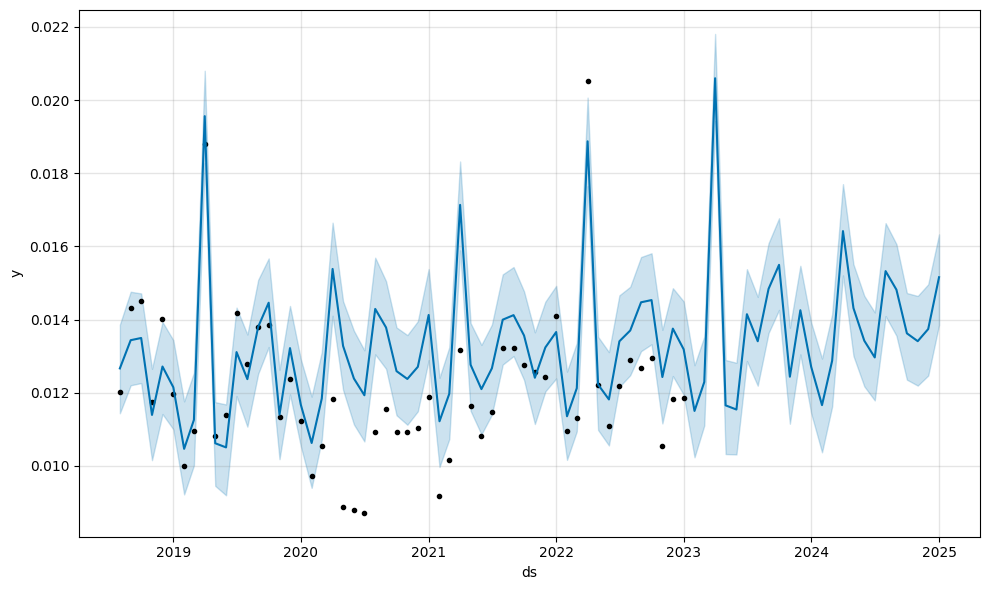

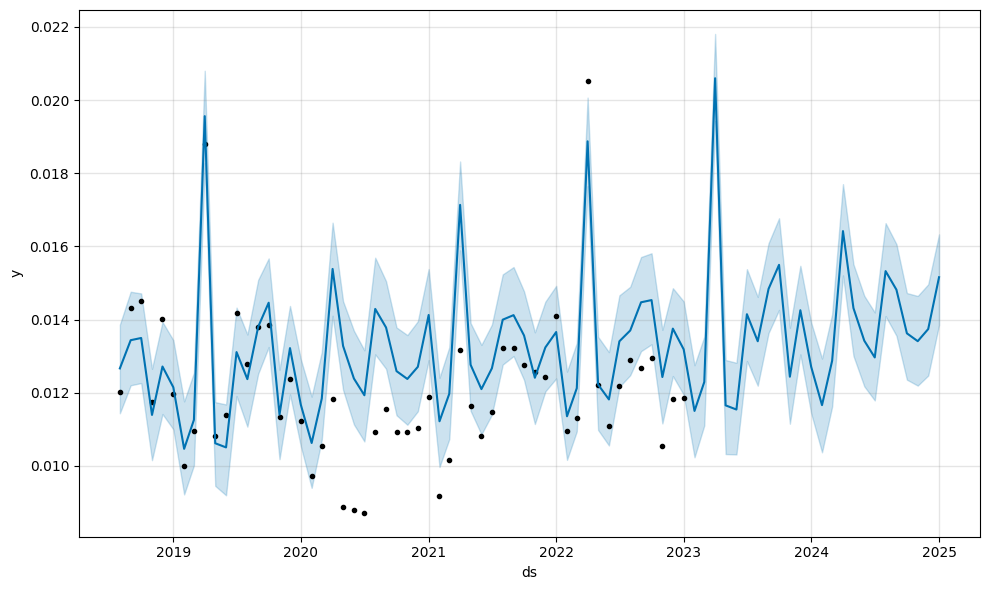

In [121]:
model.plot(forecast)

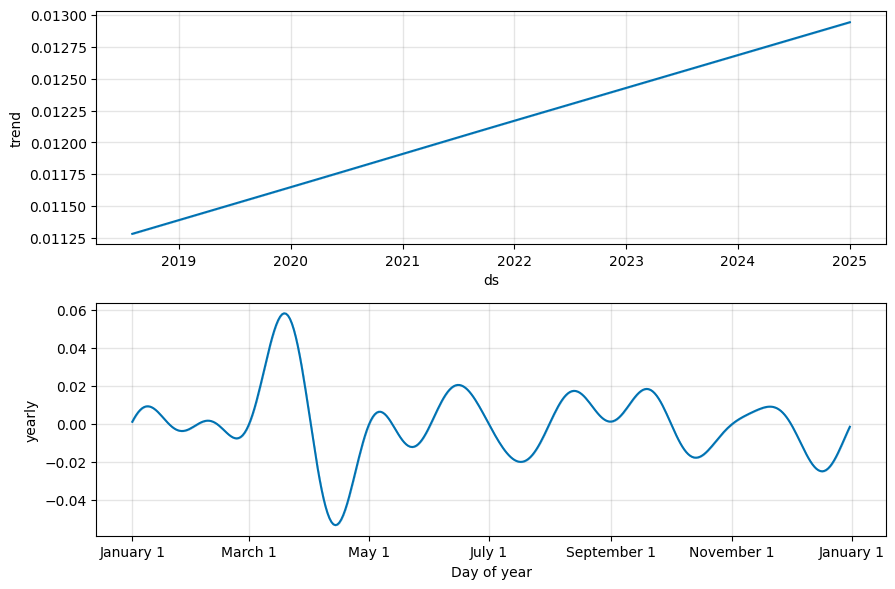

In [122]:
_ = model.plot_components(forecast)

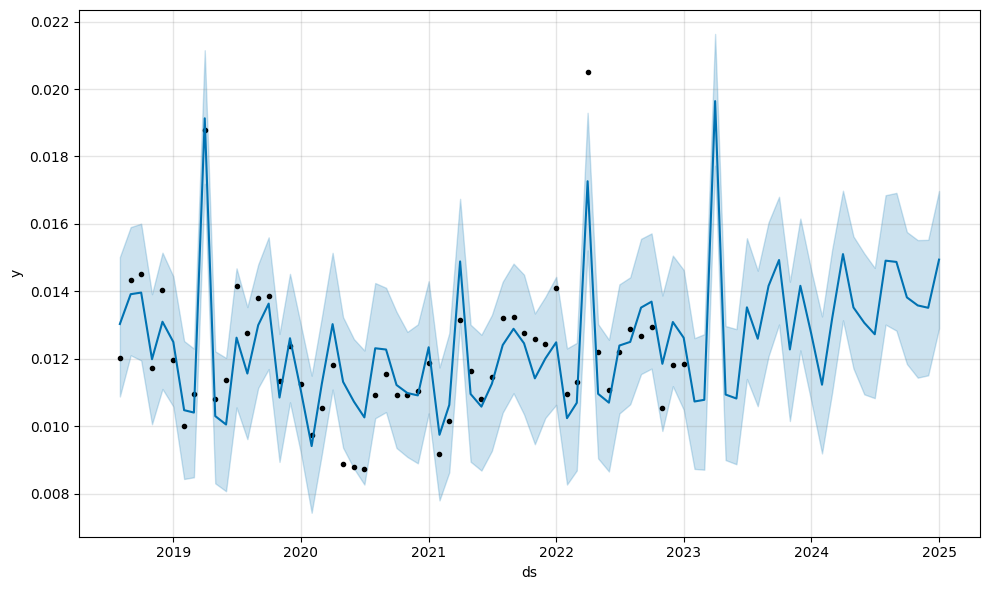

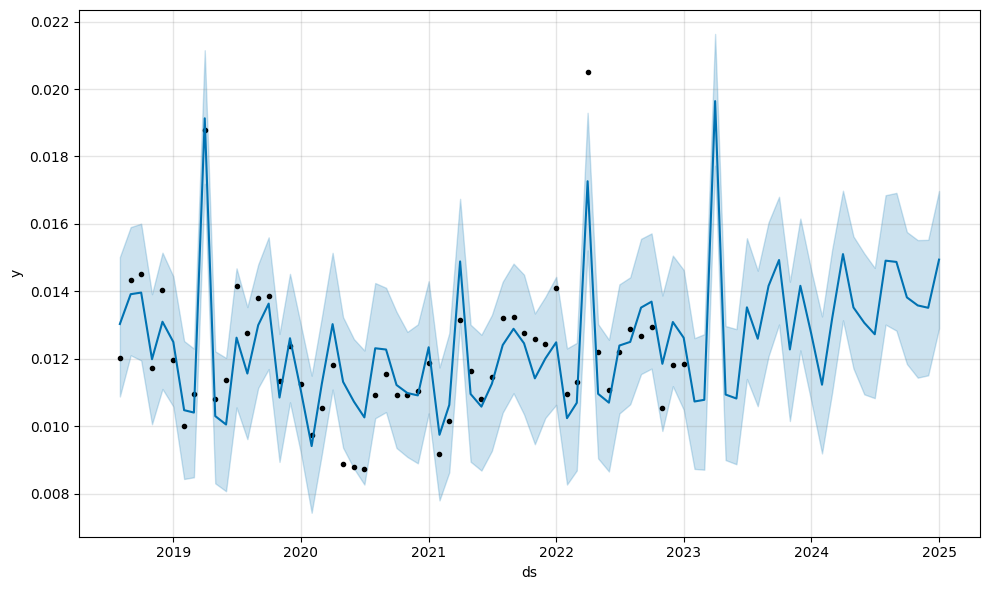

In [115]:
model.plot(prophet_forecast)

## Adding events (and COVID)

[https://towardsdatascience.com/using-prophet-after-covid-read-this-first-fc27cd77f3d7](https://towardsdatascience.com/using-prophet-after-covid-read-this-first-fc27cd77f3d7)

We can treat COVID like as a "holiday" event (functionality to account for the impact of holidays on data exists in Prophet architecture.

In [33]:
COVID_lockdown = pd.DataFrame({
        'holiday': 'covid',
        'ds':  pd.date_range(start='2020-03-15', 
                             end='2020-05-01',
                             freq='D'),
        'lower_window': 0,
        'upper_window': 0,
        'prior_scale': 1 
        })

Or could specify "pre covid" and "post covid" seasonalities.

Or could add COVID-related regressors, such as google mobility. **Note** \- can we use UK-only mobility data? As this would be most aligned to NHS trends.

In [34]:
#add a list of external regressors
regressors = ['CCI','google mobility','covid cases']
for regressor in regressors:
            base_model = base_model.add_regressor(regressor,
                                                  prior_scale=1,  
                                                 standardize='auto',   mode='multiplicative')

NameError: name 'base_model' is not defined

## Additive or Multiplicative model?

Prophet has two modes for seasonality and regressors, one is the additive mode (default), another is the multiplicative mode.

With additive mode, seasonality/regressor is constant year over year; While, with multiplicative mode, the magnitude of seasonality/regressor is changing along with trend.

Since both seasonality and regressors have two modes, there are four combinations.

Usually it makes sense to use multiplactive mode. However, things are a little different because of COVID… Due to COVID impact, the 2020 number could be very low, so if we use multiplicative seasonality, the model will be misled by the low baseline and thinks that there is a big decrease in the magnitude of seasonality from 2019 to 2020, and then predicts that magnitude of 2021’s seasonality is even smaller than 2020’s. The model predictions could be seriously underestimated by using multiplicative.

With the above said, it makes more sense to use additive seasonality during the pandemic so that it’s not biased by 2020’s abnormal baseline, especially when COVID greatly impacts your time series data. When we come out of the pandemic, we may need to revisit the model hyperparameters.

## Evaluating model fit

Take from prophet\_exercises\_SOLUTIONS

In [117]:
yp_train = prophet_training_data(y_train[:-28])
yp_test = prophet_training_data(y_train[-28:])

In [118]:
print(y_train.shape)

(54, 1)


In [119]:
print(yp_train.shape)

(26, 2)


In [120]:
print(yp_test.shape)

(28, 2)


In [121]:
import numpy as np
from forecast_tools.datasets import load_emergency_dept
from forecast_tools.model_selection import auto_naive 

In [122]:
best = auto_naive(y_train[:-28], horizon=15)
best

{'model': Drift(), 'mae': 0.004898441946590462}

In [123]:
from forecast_tools.baseline import EnsembleNaive

ens = EnsembleNaive(1)
ens_preds = ens.fit_predict(y_train[:-28], horizon=28)

In [124]:
model = Prophet(interval_width=0.95, daily_seasonality=False)
model.add_country_holidays(country_name='UK')
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(yp_train)
future = model.make_future_dataframe(periods=28,freq='MS')
prophet_forecast = model.predict(future)
#_ = model.plot_components(prophet_forecast);

14:54:39 - cmdstanpy - INFO - Chain [1] start processing


14:54:43 - cmdstanpy - INFO - Chain [1] done processing


In [125]:
from forecast_tools.metrics import forecast_errors # creates range of forecast errors
# below is forecast errors for SNaive
# ~12% error
forecast_errors(y_train[-28:], prophet_forecast['yhat'].iloc[-28:].to_list())

{'me': 0.05756040611521075,
 'mae': 0.05843443694258562,
 'mse': 0.004727536496100446,
 'rmse': 0.06875708324311355,
 'mape': 51.270960976628146,
 'smape': 81.12050246524355}

In [126]:
forecast_errors(y_train[-28:], ens_preds)

{'me': 0.016716987087863785,
 'mae': 0.01892564427635774,
 'mse': 0.0005368297588399821,
 'rmse': 0.023169586937189495,
 'mape': 15.561613684743639,
 'smape': 17.39688202238102}